# PROJECT 3

## Part 1: Prediction quality vs feature selection

In [64]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LassoCV, Lasso, LogisticRegression, LogisticRegressionCV
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.utils import shuffle

Hyperparameter $\lambda$ are instead $\alpha$ in LassoCV

`alpha_` contains hyperparameter that achieved lowest MSE

`alphas_` contains all tested hyperparameters

Coeffs of `Lasso` can be found in `coef_`

`mse_path_` a `(len(alphas_) x n_folds)` matrix storing test error on each fold

Vectors **e** and **s** can easily be computed from `mse_path_`

In [65]:
# Function to simulate data from the thesis
def simulate_data(n, p, rng, sparsity=0.95, SNR=2.0, beta_scale=5.0):
    """Simulate data for Project 3, Part 1.

    Parameters
    ----------
    n : int
        Number of samples
    p : int
        Number of features
    rng : numpy.random.Generator
        Random number generator (e.g. from `numpy.random.default_rng`)
    sparsity : float in (0, 1)
        Percentage of zero elements in simulated regression coefficients
    SNR : positive float
        Signal-to-noise ratio (see explanation above)
    beta_scale : float
        Scaling for the coefficient to make sure they are large

    Returns
    -------
    X : `n x p` numpy.array
        Matrix of features
    y : `n` numpy.array
        Vector of responses
    beta : `p` numpy.array
        Vector of regression coefficients
    """
    X = rng.standard_normal(size=(n, p))
    
    q = int(np.ceil((1.0 - sparsity) * p))
    beta = np.zeros((p,), dtype=float)
    beta[:q] = beta_scale * rng.standard_normal(size=(q,))
    
    sigma = np.sqrt(np.sum(np.square(X @ beta)) / (n - 1)) / SNR

    y = X @ beta + sigma * rng.standard_normal(size=(n,))

    # Shuffle columns so that non-zero features appear
    # not simply in the first (1 - sparsity) * p columns
    idx_col = rng.permutation(p)
    idx_row = rng.permutation(n)
    X = X[idx_row, :]
    y = y[idx_row]
    
    return X[:, idx_col], y, beta[idx_col]

Suggestions for parameters:<br>
- `p` - something large, e.g. `500` or `1000`<br>
- `n` - vary compared to p, e.g. iterate through `[200, 500, 750]` if `p = 1000`<br>
what truly matters is the ratio `p/n`, <br>
if you change `p`, adjust choices of `n`<br>
- `sparsity` - vary for a few choices e.g. `[0.75, 0.9, 0.95, 0.99]`<br>
- `SNR` - fix at something reasonable like `2` or `5`<br>
- `beta_scale` - fix at maybe `5` or `10`<br>

Questions
- How des the MSE of the $\lambda_{min}$ and $\lambda_{1se}$ models behave for different $n$ and sparsity levels?
- What differences between sensitivity/specificity computed from the $\lambda_{min}$ and the $\lambda_{1se}$ models can you observe?
- How do different choices for `n` and `sparisty` affect the relationship of sensitivity/specifity?

In [209]:
p = 500 # 500
nmin = 100 # 100
nmax = p-nmin
nn = 3# 3
n = np.linspace(nmin, nmax, nn)
sparsity = [0.75, 0.9, 0.95, 0.99]
# sparsity = [0.75]
SNR = 2
beta_scale = 5
print(n)
NNN = 500

[100. 250. 400.]


In [210]:
# Do lassoCV over different n and sparsity. Avarage over a number of times.
# There is some temporary code in comments for selecting just 1 alpha_1se for later in the project

# p = 500
# beta_scale = 5
# n = [1000]
# sparsity = 0.95
# SNR = 2

rng = np.random.default_rng()
n_runs = 5
n_folds = 5
train_frac = 0.8
# Dictionary with the alpha_min and alpha_1se.
# Each list will contain the data for each value of n
MSEtrain = {'min':[], '1se':[]}
MSEtest = {'min':[], '1se':[]}
sensitivity = {'min':[], '1se':[]}
specificity = {'min':[], '1se':[]}
# temp_alpha_min = []
# temp_apha_1se = []

# With len(n)=3 and len(sparsity)=4 and 5 repeats,
# we will run thourgh 60 datasets, be aware
for cn in n:
    MSE_train_list = [[], []]
    MSE_test_list = [[], []]
    sensitivity_list = [[], []]
    specificity_list = [[], []]
    for csparsity in sparsity:
        MSE_train_1se = []
        MSE_train_min = []
        MSE_test_1se = []
        MSE_test_min = []
        sensitivity_min = []
        sensitivity_1se = []
        specificity_min = []
        specificity_1se = []

        for _ in range(n_runs):
            X, y, beta = simulate_data(int(cn)+NNN, p, rng, csparsity, SNR, beta_scale)

            train_idx = int(cn)
            
            # split into training and test
            trainX = X[0:train_idx]
            trainy = y[0:train_idx]
            testX = X[train_idx:]
            testy= y[train_idx:]
            # fit lassoCV to training data
            lasso = LassoCV(cv=n_folds).fit(trainX, trainy)
            # temp_alpha_min.append(lasso.alpha_)
            # extract betas
            beta_est_min = lasso.coef_
            non_zero_idx = np.nonzero(beta_est_min)[0]
            selected_features_est_min = deepcopy(beta_est_min)   
            selected_features_est_min[non_zero_idx] = 1 
            # code from thesis to get alpha_min and alpha_1se
            cv_mean = np.mean(lasso.mse_path_, axis=1)
            cv_std = np.std(lasso.mse_path_, axis=1)
            idx_min_mean = np.argmin(cv_mean)
            idx_alpha = np.where(
                (cv_mean <= cv_mean[idx_min_mean] + cv_std[idx_min_mean] / np.sqrt(n_folds)) &
                (cv_mean >= cv_mean[idx_min_mean])
            )[0][0]
            alpha_1se = lasso.alphas_[idx_alpha]
            # temp_apha_1se.append(alpha_1se)

            # extract data of MSE from alpha_min and alpha_1se
            # jag tror det här är rätt men inte helt 100
            MSE_train_min.append(cv_mean[idx_min_mean])
            MSE_train_1se.append(cv_mean[idx_alpha])

            # predict test data, with alpha_min
            test_pred_min = lasso.predict(testX)
            MSE_test_min.append(mean_squared_error(testy, test_pred_min))           

            # refit on training data with specific alpha and predict on test data
            upd_lasso = Lasso(alpha_1se).fit(trainX, trainy)
            test_pred_1se = upd_lasso.predict(testX)
            MSE_test_1se.append(mean_squared_error(testy, test_pred_1se))
            # extract betas from lasso model with alpha_1se
            beta_est_1se = upd_lasso.coef_
            non_zero_idx = np.nonzero(beta_est_1se)[0]
            selected_features_est_1se = deepcopy(beta_est_1se)
            selected_features_est_1se[non_zero_idx] = 1

            # make the true betas a 1-0-vector
            non_zero_idx = np.nonzero(beta)[0]
            selected_features_true = deepcopy(beta)
            selected_features_true[non_zero_idx] = 1
            
            cm_min = confusion_matrix(selected_features_true, selected_features_est_min)
            cm_1se = confusion_matrix(selected_features_true, selected_features_est_1se)
            # TP = confusion[1,1] # true positives
            # TN = confusion[0,0] # true negatives
            # FP = confusion[0,1] # false positives
            # FN = confusion[1,0] # false negatives
            sensitivity_min.append(cm_min[1,1]/(cm_min[1,0]+cm_min[1,1]))
            sensitivity_1se.append(cm_1se[1,1]/(cm_1se[1,0]+cm_1se[1,1]))
            specificity_min.append(cm_min[0,0]/(cm_min[0,0]+cm_min[0,1]))
            specificity_1se.append(cm_1se[0,0]/(cm_1se[0,0]+cm_1se[0,1]))

        # this is messy, but it works. Saving all data to be able to do
        # mean and std afterwards
        MSE_train_list[0].append(MSE_train_min)
        MSE_train_list[1].append(MSE_train_1se)
        MSE_test_list[0].append(MSE_test_min)
        MSE_test_list[1].append(MSE_test_1se)
        sensitivity_list[0].append(sensitivity_min)
        sensitivity_list[1].append(sensitivity_1se)
        specificity_list[0].append(specificity_min)
        specificity_list[1].append(specificity_1se)
    MSEtrain['min'].append(MSE_train_list[0])
    MSEtrain['1se'].append(MSE_train_list[1])
    MSEtest['min'].append(MSE_test_list[0])
    MSEtest['1se'].append(MSE_test_list[1])
    sensitivity['min'].append(sensitivity_list[0])
    sensitivity['1se'].append(sensitivity_list[1])
    specificity['min'].append(specificity_list[0])
    specificity['1se'].append(specificity_list[1])


c:\Users\rasmu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.040e+02, tolerance: 4.938e+01
  model = cd_fast.enet_coordinate_descent(


In [211]:
# print(np.mean(temp_alpha_min))
# print(np.mean(temp_apha_1se))


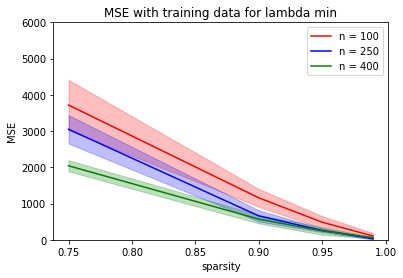

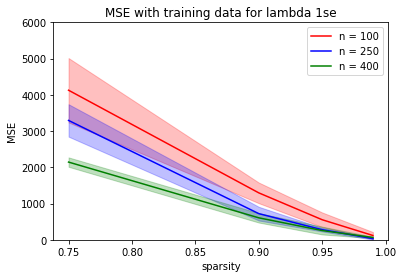

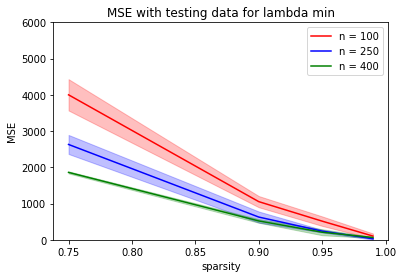

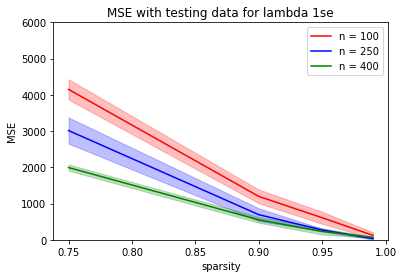

In [212]:
# plot MSE against sparsity for different n
# add std shaded areas to the curves
c = ['red', 'blue', 'green']
t = ['min', '1se']
for ci, ct in enumerate(t):
    plt.figure(ci)
    for i in range(len(n)):
        min_means = np.mean(MSEtrain[ct][i], axis=1)
        min_std = np.std(MSEtrain[ct][i], axis=1)
        min_stds = [min_means - min_std,
                    min_means + min_std]
        line, = plt.plot(sparsity, min_means, c[i])
        line.set_label(f'n = {int((n[i]))}')
        plt.fill_between(sparsity, min_stds[0], min_stds[1], color=c[i], alpha=0.25)
    plt.title(f'MSE with training data for lambda {ct}')
    plt.ylim(0, 6000)
    plt.xlabel('sparsity')
    plt.ylabel('MSE')
    plt.legend()
for ci, ct in enumerate(t):
    plt.figure(ci+2)
    for i in range(len(n)):
        min_means = np.mean(MSEtest[ct][i], axis=1)
        min_std = np.std(MSEtest[ct][i], axis=1)
        min_stds = [min_means - min_std,
                    min_means + min_std]
        line, = plt.plot(sparsity, min_means, c[i])
        line.set_label(f'n = {int((n[i]))}')
        plt.fill_between(sparsity, min_stds[0], min_stds[1], color=c[i], alpha=0.25)
    plt.title(f'MSE with testing data for lambda {ct}')
    plt.ylim(0, 6000)
    plt.xlabel('sparsity')
    plt.ylabel('MSE')
    plt.legend()

In [213]:
# calculate means and stds for sensitivity and specificity
# specificity is never used for the plot however
k = ['min', '1se']
sens={'min':[], '1se':[]}
spec={'min':[], '1se':[]}
for ckey in k:
    means_sens = np.mean(sensitivity[ckey], axis=2)
    means_spec = np.mean(specificity[ckey], axis=2)
    stds_sens = np.std(sensitivity[ckey], axis=2)
    stds_spec = np.std(specificity[ckey], axis=2)
    plt_stds_sens = [means_sens-stds_sens, means_sens+stds_sens]
    plt_stds_spec = [means_spec-stds_spec, means_spec+stds_spec]
    sens[ckey] = [means_sens, plt_stds_sens]
    spec[ckey] = [means_spec, plt_stds_spec]

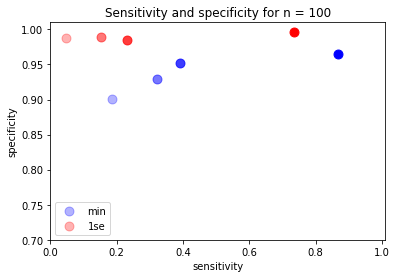

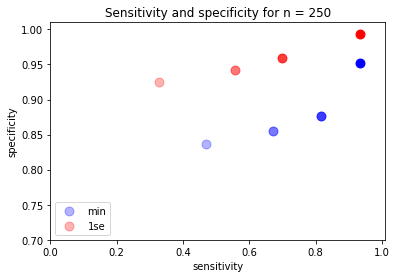

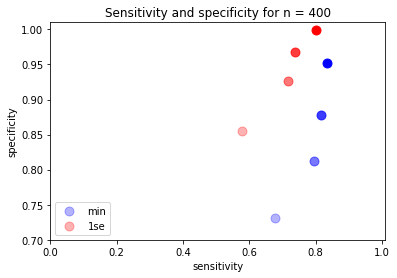

In [214]:
# plot specificity vs sensitivity for alpha_min and alpha_1se for different n
# shade the dots depending on sparsity value
fs = 15
shade = np.linspace(0.3, 1, 4)
for ci, cn in enumerate(n):
    plt.figure(ci)
    for cj, _ in enumerate(sens['min'][0][ci]):
        plt.scatter(sens['min'][0][ci][cj], spec['min'][0][ci][cj], s=80, color='blue', alpha=shade[cj])
        plt.scatter(sens['1se'][0][ci][cj], spec['1se'][0][ci][cj], s=80, color='red', alpha=shade[cj])
    plt.ylim(0.7,1.01)
    plt.xlim(0,1.01)
    plt.xlabel('sensitivity')
    plt.ylabel('specificity')
    plt.title(f'Sensitivity and specificity for n = {int(cn)}')
    plt.legend(['min', '1se'], loc='lower left')
    


Questions

What differences between sensitivity/specificity computed from the $\lambda_{min}$ and the $\lambda_{1se}$ models can you observe?
- They seem to follow the same kind of curve, 1se always above min

How do different choices for n and sparsity affect the relationship of sensitivity/specificity?
- Higher sparsity seems to push them together, maybe????

## Part 2: Selecting features with confidence

In [72]:
# load the gene expression data set
workload_data_df = pd.read_csv(index_col=0, filepath_or_buffer='data.csv')
labeled_data_df = pd.read_csv(index_col=0, filepath_or_buffer='labels.csv')

In [221]:
n_of_features = 200
variances = workload_data_df.var()
var_lim = 0
ind = []
# remove data points with 0 variance. Otherwise SelectKBest wont work
for i, var in enumerate(variances):
    if var > var_lim:
        ind.append(i)

workload_data_df = workload_data_df.iloc[:, ind]
SKB = SelectKBest(score_func=f_classif, k=n_of_features)
SKB.fit(workload_data_df, labeled_data_df['Class'])
idx_200selected = SKB.get_support(True)
trimmed_data = SKB.fit_transform(workload_data_df, labeled_data_df['Class'])
# trimmed_data = SelectKBest(score_func=f_classif, k=n_of_features).fit(workload_data_df, labeled_data_df['Class'])
trimmed_data.shape


(801, 200)

In [222]:
# array of different penalty parameters for the CV
hp = np.logspace(-4, 4, 30)
n_folds = 5

# scoring can be anything from sklearn.metrics
# import sklearn
# sorted(sklearn.metrics.SCORERS.keys())
lr_cv = LogisticRegressionCV(Cs=hp, cv=n_folds, scoring='f1', penalty='l1', 
                        multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(trimmed_data, labeled_data_df['Class'])


In [234]:
# For each fold, and label get C_max and C_1se
# currently C_max and C_1se are always the same
# The score is always 1 or very close to 1 for 
# some of the Cs and corresponding std is always 0.
# Feels like there is something in the LogisticRegressionCV
# function is not really doing what expected

labels = ['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD']
C_max_list = []
C_1se_list = []
for cl in labels:
    cv_mean = np.mean(lr_cv.scores_[cl], axis=0)
    cv_std = np.std(lr_cv.scores_[cl], axis=0)
    idx_max_mean = np.argmax(cv_mean)
    idx_1se_mean = np.where(
        (cv_mean >= cv_mean[idx_max_mean] - cv_std[idx_max_mean] / np.sqrt(n_folds)) &
        (cv_mean <= cv_mean[idx_max_mean])
    )[0][0]
    C_max_list.append(lr_cv.Cs_[idx_max_mean])
    C_1se_list.append(lr_cv.Cs_[idx_1se_mean])
    
C_max = max(C_max_list)
C_1se = max(C_1se_list)
print(C_max, C_1se)
# print(C_max_list)
# print(C_1se_list)
# print(lr_cv.C_)


788.0462815669904 788.0462815669904


In [244]:
# bootstrap LogisticRegression and save the nonzero coefficients for each iteration
M = 1000
total_selected_features_est = np.zeros([5, 200])
for _ in range(M):
    samples = np.random.choice(range(len(trimmed_data)), len(trimmed_data))
    cb_data = np.array([trimmed_data[dp] for dp in samples])
    cb_labels = np.array([labeled_data_df['Class'][dp] for dp in samples])
    lr = LogisticRegression(C=C_max, penalty='l1', multi_class='ovr', solver='liblinear', intercept_scaling=10000).fit(cb_data, cb_labels)
    beta_est = lr.coef_
    selected_features_est = deepcopy(beta_est)
    for i, _ in enumerate(beta_est):
        non_zero_idx = np.nonzero(beta_est[i])[0]
        selected_features_est[i][non_zero_idx] = 1
    total_selected_features_est += selected_features_est



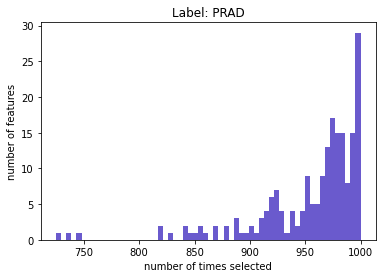

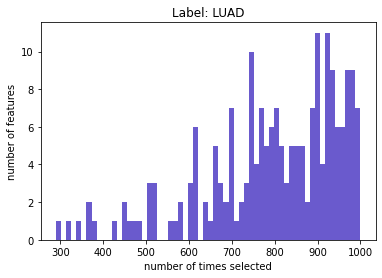

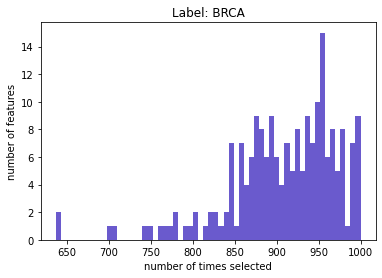

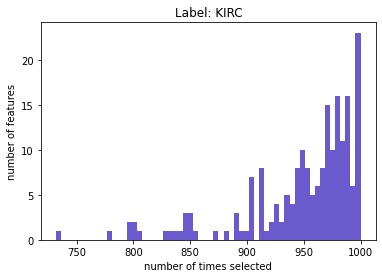

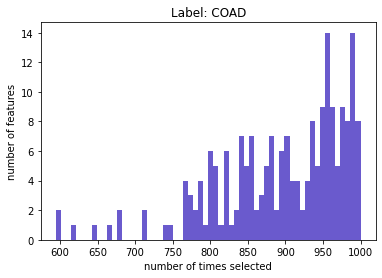

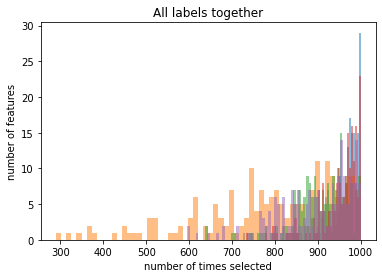

In [246]:
# plot histograms of number of features that are selected over the bootstrap iterations
bins = 60
for i, l in enumerate(labels):
    plt.figure(i)
    plt.hist(total_selected_features_est[i], bins=bins, color='slateblue')
    plt.title(f'Label: {l}')
    plt.xlabel('number of times selected')
    plt.ylabel('number of features')

for i in range(len(labels)):
    plt.figure(5)
    plt.hist(total_selected_features_est[i], bins=bins, alpha=0.5)
    plt.title('All labels together')
    plt.xlabel('number of times selected')
    plt.ylabel('number of features')

In [208]:
imp_features = {'PRAD':[], 'LUAD':[], 'BRCA':[], 'KIRC':[], 'COAD':[]}
all_f = []
for i, l in enumerate(labels):
    for j in range(M):
        idx_M = np.where(total_selected_features_est[i]>=M-j)[0]
        if len(idx_M) >= 5:
            imp_features[l].append([idx_200selected[idx_M], j])
            all_f.append(list(idx_200selected[idx_M]))
            break

print(imp_features)
all_f_f = [item for sublist in all_f for item in sublist]
all_f_f.sort()
print(all_f_f)

{'PRAD': [[array([ 5397,  7949,  9630, 15866, 16340, 17547, 18492], dtype=int64), 1]], 'LUAD': [[array([ 3438,  3521,  7228, 11527, 11989], dtype=int64), 73]], 'BRCA': [[array([ 1856,  3437,  3539,  6723,  8332, 12953], dtype=int64), 9]], 'KIRC': [[array([ 6584,  9161,  9630, 15862, 15866], dtype=int64), 9]], 'COAD': [[array([ 3735,  9159,  9160, 13952, 17881], dtype=int64), 24]]}
[1856, 3437, 3438, 3521, 3539, 3735, 5397, 6584, 6723, 7228, 7949, 8332, 9159, 9160, 9161, 9630, 9630, 11527, 11989, 12953, 13952, 15862, 15866, 15866, 16340, 17547, 17881, 18492]


Questions

What are the 5 most important features for each class?
- Might have done something wrong since we get that around 50 features gets selected M=50 times. Perhaps the chosen C is wrong.

Are there features that appear often in two or more classes simultaneously?
- Definetely seems like it


## Part 3: Selecting features with confidence - a simulation study

Please look at the demo codes and think about how to generalize your Part 1 code to include feature correlations.

### Question 1

In [148]:
def bootstrap_feature_est(X, y, M, alpha):
# perform bootstrap on lasso
    total_selected_features_est = np.zeros(p)
    for _ in range(M):
        samples = np.random.choice(range(len(X)), len(X))
        cb_data = np.array([X[dp] for dp in samples])
        cb_labels = np.array([y[dp] for dp in samples])
        lasso = Lasso(alpha).fit(cb_data, cb_labels)
        beta_est = lasso.coef_
        selected_features_est = deepcopy(beta_est)
        non_zero_idx = np.nonzero(beta_est)[0]
        selected_features_est[non_zero_idx] = 1
        total_selected_features_est += selected_features_est

    return total_selected_features_est

def histogrammer(data, n_data, title):
    bins = 30
    color = 'slateblue'
    for i, cd in enumerate(data):
        plt.hist(cd, bins=bins, color=color)
        plt.title(f'{title} = {n_data[i]:.2f}')
        plt.xlabel('number of times selected')
        plt.ylabel('number of features')
        plt.show()
    return

def vliner(data, n_data, title):
    lw = 2
    tc = 'red'
    ec = 'blue'
    for i, cest_data in enumerate(data['est'][0]):

        fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [5, 1]})
        fig.set_figwidth(10)
        ax1.vlines(cest_data, 0, 0.5, linewidth=lw, color=ec)
        ax1.vlines(data['true'][0][i], 0, 0.5, linewidth=lw, color=tc)
        ax1.set_title(f'{title} = {n_data[i]:.2f}')
        ax1.set_xlabel('feature index')
        ax1.legend(['false', 'true'])
        bools = ['true', 'false']
        counts = [len(data['true'][0][i]), len(cest_data)-len(data['true'][0][i])]
        ax2.bar(bools, counts, color='black')

        plt.show()

def thresholder(data, frac, n_data):
    threshold_idx = []
    true_idx = []
    for i in range(n_data):
        cthreshold_idx = np.where(data['est'][i] >= frac)[0]
        threshold_idx.append(cthreshold_idx)
        true_features_est = data['true'][i][cthreshold_idx]
        true_features_est_idx = np.where(true_features_est > 0)[0]
        true_idx.append(cthreshold_idx[true_features_est_idx])
    return threshold_idx, true_idx

In [80]:
M = 100
p = 500
beta_scale = 5
st_n = 1000
st_sparsity = 0.95
st_SNR = 2
st_alpha = 0.992 # from part 1

n_n = 5
SNR = np.linspace(0.5, 5, n_n)
n = np.linspace(100, 1000, n_n)
sparsity = np.linspace(0.5, 0.99, n_n)
alpha = np.linspace(0.5, 1.5, n_n)

selected_features = {'SNR':{'est':[], 'true':[]}, 'n':{'est':[], 'true':[]},
                    'sparsity':{'est':[], 'true':[]}, 'alpha':{'est':[], 'true':[]}}

f_keys = ['SNR', 'n', 'sparsity', 'alpha']
varying_data = {'SNR':SNR, 'n':n, 'sparsity':sparsity, 'alpha':alpha}
for ckey in f_keys:
    for cd in varying_data[ckey]:
        if ckey == 'SNR':
            cSNR = cd
        else:
            cSNR = st_SNR
        if ckey == 'n':
            cn = int(cd)
        else:
            cn = st_n
        if ckey == 'sparsity':
            csparsity = cd
        else:
            csparsity = st_sparsity
        if ckey == 'alpha':
            calpha = cd
        else:
            calpha = st_alpha
        X, y, beta = simulate_data(cn, p, rng, csparsity, cSNR, beta_scale)
        selected_features_est = bootstrap_feature_est(X, y, M, calpha)
        selected_features[ckey]['est'].append(selected_features_est)
        non_zero_idx = np.nonzero(beta)[0]
        selected_features_true = deepcopy(beta)
        selected_features_true[non_zero_idx] = 1
        selected_features[ckey]['true'].append(selected_features_true)


    


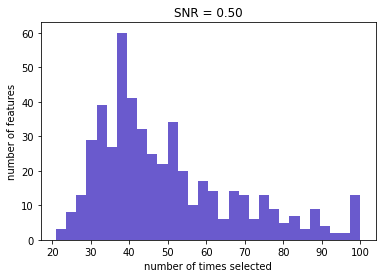

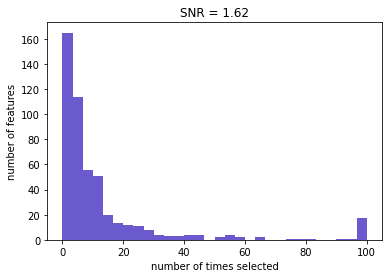

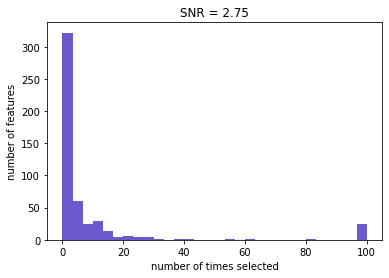

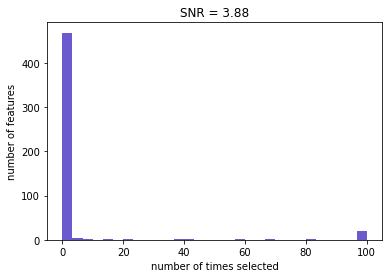

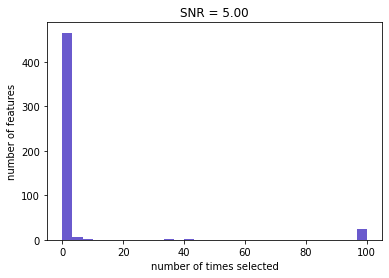

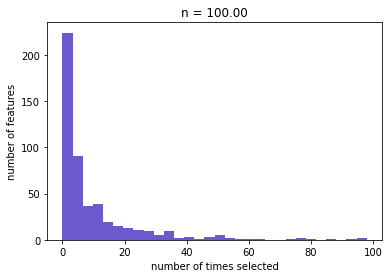

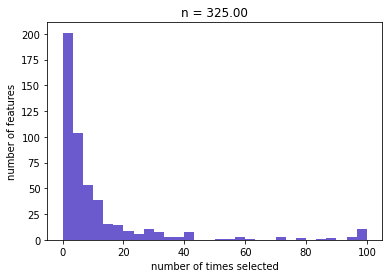

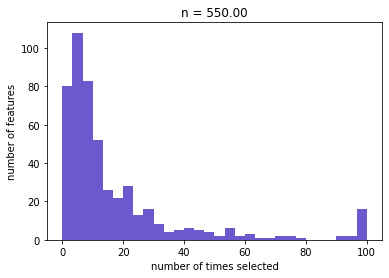

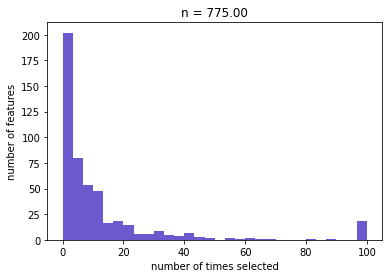

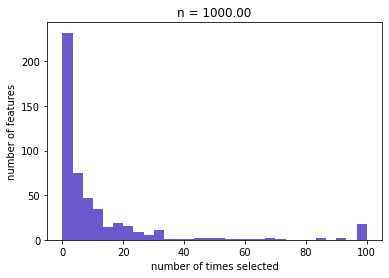

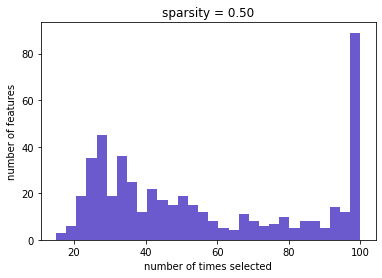

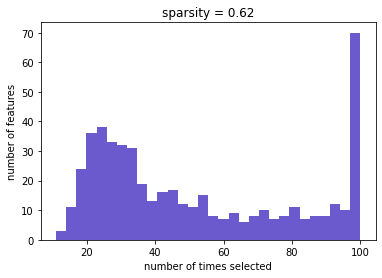

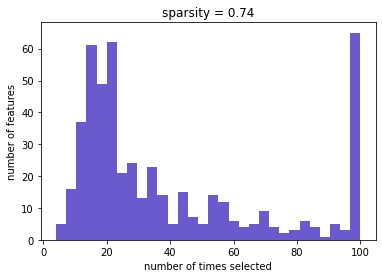

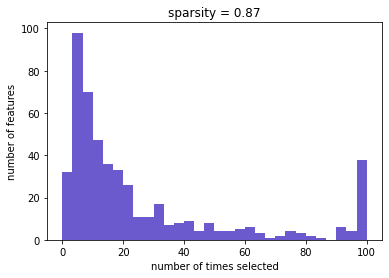

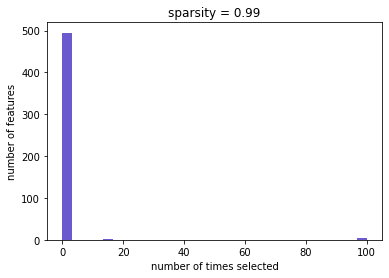

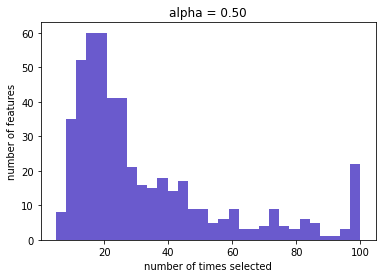

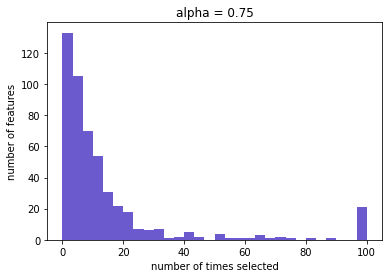

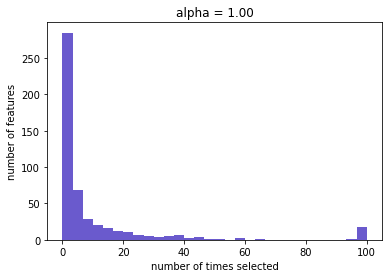

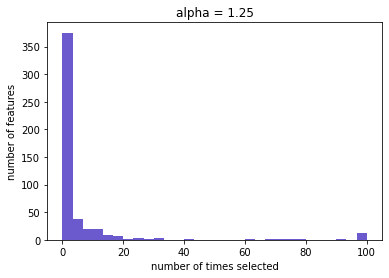

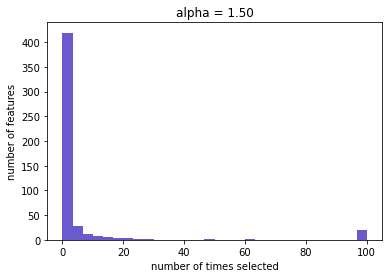

In [237]:
# plot histograms
# perhaps subplot or something, maybe save them as files
# instead of putting them here
PlotHistograms = True
if PlotHistograms:
    for ckey in f_keys:
        histogrammer(selected_features[ckey]['est'], varying_data[ckey], ckey)



In [82]:
# thresholds
# select treshold for each histogram and implement here
# lets just try with 90%
frac = 0.9*M
all_threshold_idx = {'SNR':{'est':[], 'true':[]},  'n':{'est':[], 'true':[]},
                     'sparsity':{'est':[], 'true':[]}, 'alpha':{'est':[], 'true':[]}}
for ckey in f_keys:
    threshold_idx, true_idx = thresholder(selected_features[ckey], frac, n_n)
    all_threshold_idx[ckey]['est'].append(threshold_idx)
    all_threshold_idx[ckey]['true'].append(true_idx)



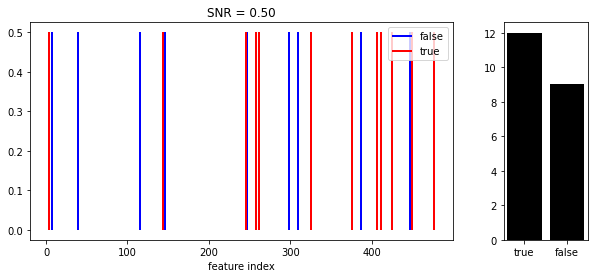

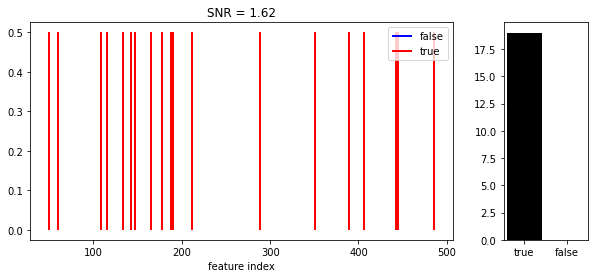

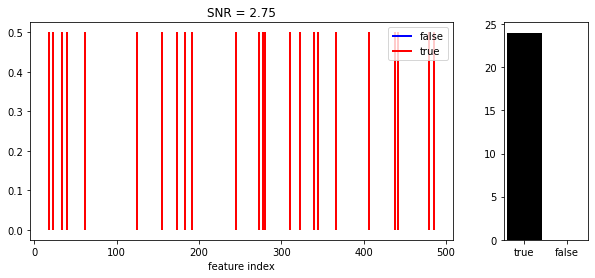

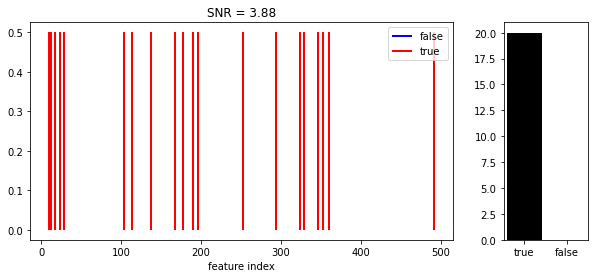

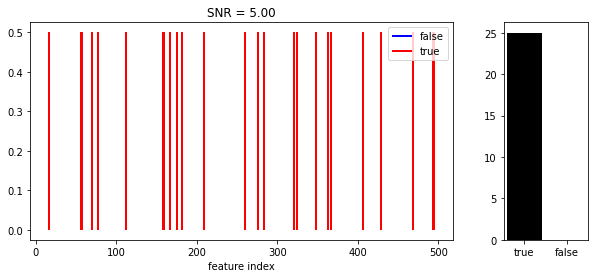

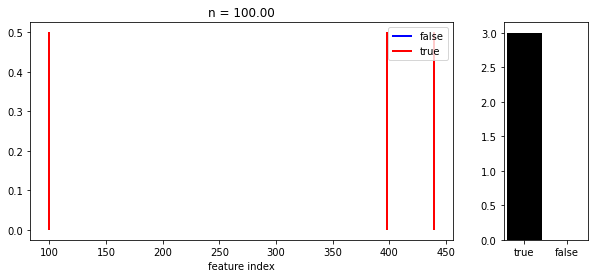

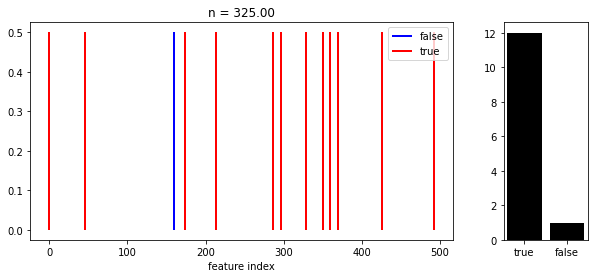

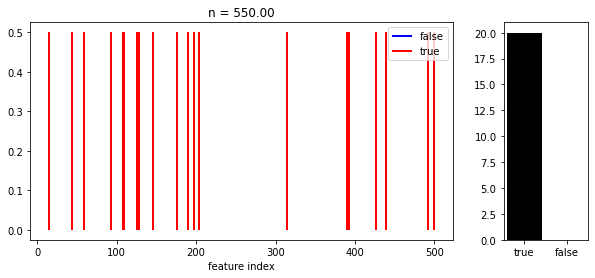

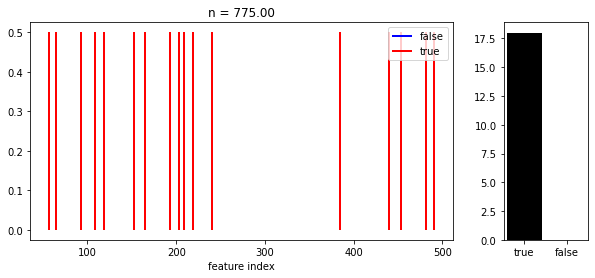

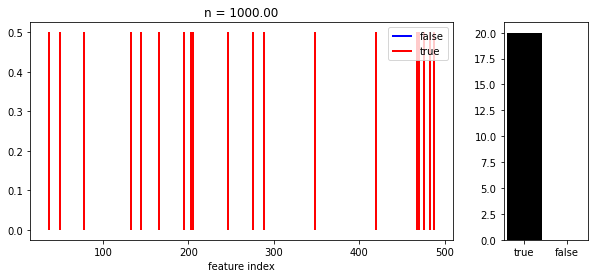

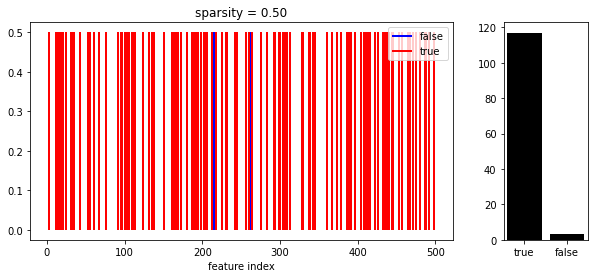

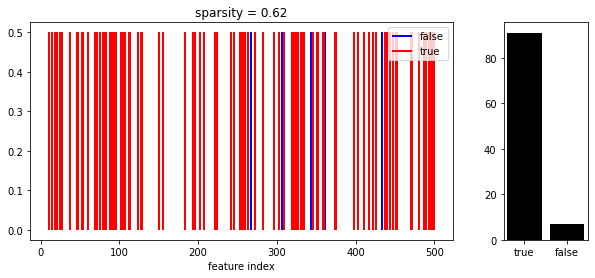

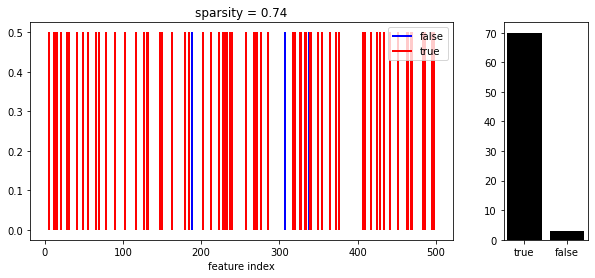

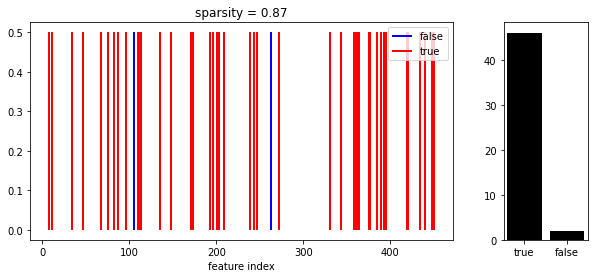

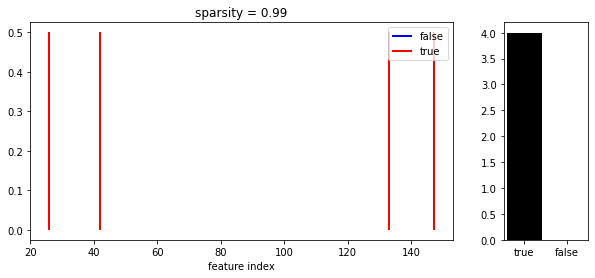

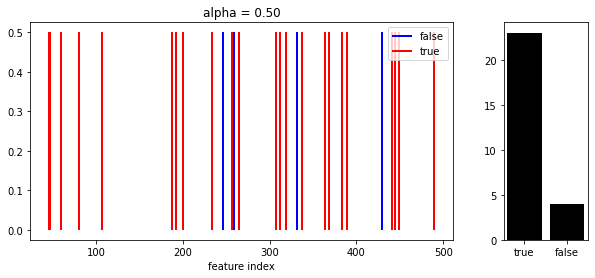

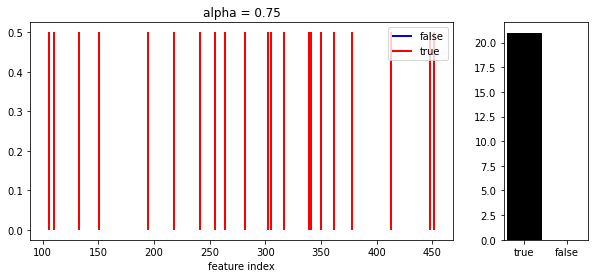

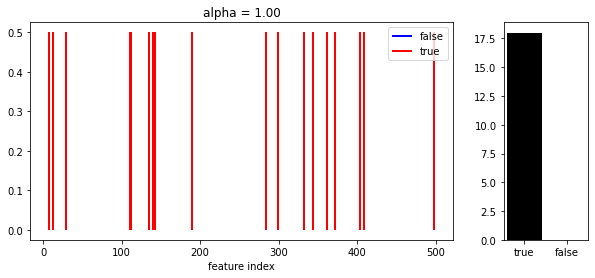

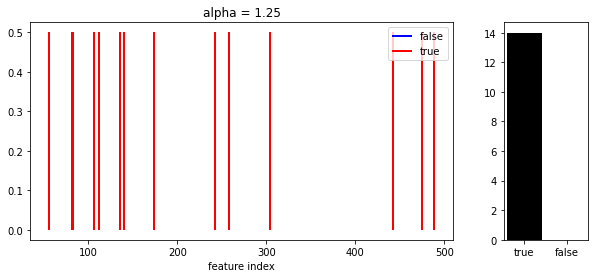

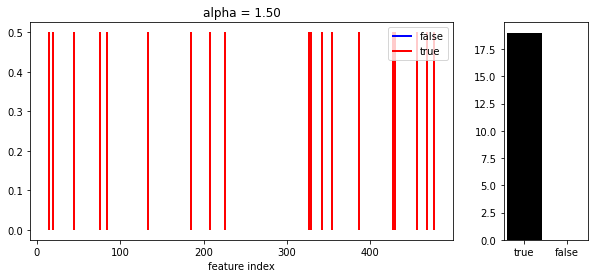

In [238]:
# an attempt to visualise estimated features vs true features
# blue line is estimated feature and red line is true feature
lw = 3
PlotLines = True
if PlotLines:
    for ckey in f_keys:
        vliner(all_threshold_idx[ckey], varying_data[ckey], ckey)


In [84]:
# out of th chosen feaures, how many are correct.
# Dont know if this makes any sense
frac_correct = {'SNR':[], 'n':[], 'sparsity':[], 'alpha':[]}
for ckey in f_keys:
    for i, cd in enumerate(all_threshold_idx[ckey]['est'][0]):
        n_features_est = len(cd)
        n_true_features = len(all_threshold_idx[ckey]['true'][0][i])
        frac_correct[ckey].append(n_true_features/n_features_est)

### Question 2

In [85]:
fracs = M*np.array([0.6, 0.8, 0.9, 0.95])
alphas = [st_alpha-0.5, st_alpha, st_alpha+0.5]
SNR = 1.62
sparsity = 0.74

B = 10
sensitivity = []
specificity = []
for _ in range(B):
    X, y, beta = simulate_data(st_n, p, rng, sparsity, SNR, beta_scale)
    alpha_selected_features = {'est':[], 'true':[]}

    for calpha in alphas:
        features_est = bootstrap_feature_est(X, y, M, calpha)
        alpha_selected_features['est'].append(features_est)

        non_zero_idx = np.nonzero(beta)[0]
        selected_features_true = deepcopy(beta)
        selected_features_true[non_zero_idx] = 1
        alpha_selected_features['true'].append(selected_features_true)


    c_sensitivity = []
    c_specificity = []
    for cfrac in fracs:
        threshold_idx, true_idx = thresholder(alpha_selected_features, cfrac, len(alphas))

        ca_sensitivity = []
        ca_specificity = []
        for i, calpha_threshold in enumerate(threshold_idx):
            selected_feautures_est = np.zeros(p)
            selected_feautures_est[calpha_threshold] = 1
            cm = confusion_matrix(selected_feautures_est, alpha_selected_features['true'][i])
            ca_sensitivity.append(cm[1,1]/(cm[1,0]+cm[1,1]))
            ca_specificity.append(cm[0,0]/(cm[0,0]+cm[0,1]))
        c_sensitivity.append(ca_sensitivity)
        c_specificity.append(ca_specificity)
    sensitivity.append(c_sensitivity)
    specificity.append(c_specificity)

mean_sensitivity = np.mean(sensitivity, axis=0)
std_sensitivity = np.std(sensitivity, axis=0)
mean_specificity = np.mean(specificity, axis=0)
std_specificity = np.std(specificity, axis=0)

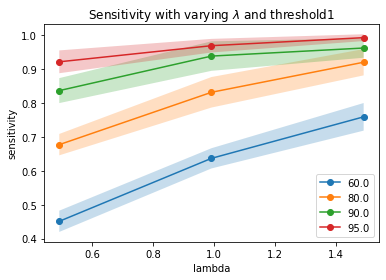

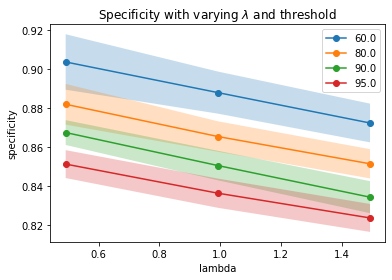

In [169]:
for cm_sens, cstd_sens, cfrac  in zip(mean_sensitivity, std_sensitivity, fracs):
    line, = plt.plot(alphas, cm_sens, 'o-')
    line.set_label(cfrac)
    cstd = [cm_sens-cstd_sens, cm_sens+cstd_sens]
    plt.fill_between(alphas, cstd[0], cstd[1], alpha=0.25)
plt.xlabel('lambda')
plt.ylabel('sensitivity')
plt.legend()
plt.title(r'Sensitivity with varying $\lambda$ and threshold')
plt.show()

for cm_spec, cstd_spec, cfrac in zip(mean_specificity, std_specificity, fracs):
    line, = plt.plot(alphas, cm_spec, 'o-')
    line.set_label(cfrac)
    cstd = [cm_spec-cstd_spec, cm_spec+cstd_spec]
    plt.fill_between(alphas, cstd[0], cstd[1], alpha=0.25)
plt.xlabel('lambda')
plt.ylabel('specificity')
plt.title(r'Specificity with varying $\lambda$ and threshold')
plt.legend()
plt.show()


TODO: 
- all plots needs to be better
- maybe plot/visualise the simulated data in part 1